In [1]:
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('/users/ouyang/desktop/CSE7324MachineLearning/Datasets/mobile-price-classification/train.csv')
df.head(5)

X = np.array(df.iloc[:,:20])
y = np.array(df.iloc[:,-1])

# Split the dataset into trian_set and test_set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)


In [28]:
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

class TwoLayerPerceptron(object):
    def __init__(self, n_hiddens_size=(30,), C=0.0, epochs=500, eta=0.001, random_state=None, alpha=0.0, decrease_const=0.0, 
                 shuffle=True, minibatches=1, cost_function='quadratic',
                 act_function='sigmoid'):
        np.random.seed(random_state)
        self.n_hiddens_size = n_hiddens_size
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # different activation/cost function choice
        self.act_function = act_function
        self.cost_function = cost_function
        self.grad_w_ = []
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        # Make sure self.hidden_layer_sizes is a list
        hiddens_layers = self.n_hiddens_size
        if not hasattr(hiddens_layers, "__iter__"):
            hiddens_layers = [hiddens_layers]
        hiddens_layers = list(hiddens_layers)
        hiddens_layers += [self.n_output_]

        """Initialize weights with small random numbers."""
        weights_list = []
        pre_features = self.n_features_
        for n_hidden in hiddens_layers:
            W1_num_elems = (pre_features+1) * n_hidden
            W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
            W1 = W1.reshape(n_hidden, pre_features+1) # reshape to be W
            pre_features = n_hidden
            weights_list += [W1]
        
        return weights_list
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _linear(z):
        coef = 2;
        return coef*z
    
    @staticmethod
    def _relu(z):
        return np.maximum(0,z.copy())
    
    @staticmethod
    def _silu(z):
        z = z.copy() * expit(z.copy())
        return z
    
    def _activation_funtion(self, z):
        if self.act_function == 'linear':
            return self._linear(z)
        if self.act_function == 'sigmoid':
            return self._sigmoid(z)
        if self.act_function == 'relu':
            return self._relu(z)
        if self.act_function == 'silu':
            return self._silu(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, weights_list):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        weights = 0
        for W in weights_list:
            weights += np.mean(W[:, 1:] ** 2)
        return (lambda_/2.0) * np.sqrt(weights)
    
    def _cost(self, output ,Y_enc, weights_list):
        '''Get the objective function value'''

        if self.cost_function=='quadratic':
            cost = np.mean((Y_enc-output)**2)
        if self.cost_function=='crossentropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(output)+(1-Y_enc)*np.log(1-output))))
        
        
        L2_term = self._L2_reg(self.l2_C, weights_list)
        return cost + L2_term
    
    def _feedforward(self, X, weights_list):
        """Compute feedforward step
        """
        A_list = []
        Z_list = []
        pre_Z = None
        for idx, W in enumerate(weights_list):
            if idx == 0:
                A1 = self._add_bias_unit(X.T, how='row')
            else:
                A1 = self._activation_funtion(pre_Z)
                A1 = self._add_bias_unit(A1, how='row')
            Z1 = W @ A1
            A_list += [A1]
            Z_list += [Z1]
            pre_Z = Z1
        A_output = self._sigmoid(pre_Z)
        A_list += [A_output]
            
        return A_list, Z_list
    
    # Sigmoid_get_gradient
    def _get_gradient_sigmoid(self, A_list, Z_list, Y_enc, weights_list):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        gradients_list = []
        A_output = A_list[-1]
        
        if self.cost_function=='quadratic':
            V_last = -2*(Y_enc-A_output)*A_output*(1-A_output)  # last layer sensitivity
        elif self.cost_function=='crossentropy':
            V_last = (A_output-Y_enc)
                
        count = 1
        for A, W in zip(A_list[:-1][::-1], weights_list[::-1]):
            if count == 1:
                grad = V_last @ A.T # no bias on final layer
                V1 = A * (1 - A) * (W.T @ V_last) # back prop the sensitivity
            else:
                grad = V_last[1:,:] @ A.T # dont back prop sensitivity of bias
                V1 = A * (1 - A) * (W.T @ V_last[1:, :])
                
            # regularize weights that are not bias terms
            grad[:, 1:] += W[:, 1:] * self.l2_C
            gradients_list.insert(0, grad)
                
            V_last = V1
            
            count += 1
        return gradients_list
    
    # linear_get_gradient
    def _get_gradient_linear(self, A_list, Z_list, Y_enc, weights_list):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        gradients_list = []
        A_output = A_list[-1]
        
        if self.cost_function=='quadratic':
            V_last = -2*(Y_enc-A_output)*A_output*(1-A_output)  # last layer sensitivity
        elif self.cost_function=='crossentropy':
            V_last = (A_output-Y_enc)
            
        count = 1
        for A, W in zip(A_list[:-1][::-1], weights_list[::-1]):
            if count == 1:
                grad = V_last @ A.T # no bias on final layer
                V1 = (W.T @ V_last) # back prop the sensitivity
            else:
                grad = V_last[1:,:] @ A.T # dont back prop sensitivity of bias
                V1 = (W.T @ V_last[1:, :])
                
            # regularize weights that are not bias terms
            grad[:, 1:] += W[:, 1:] * self.l2_C
            gradients_list.insert(0, grad)
                
            V_last = V1
            
            count += 1
        return gradients_list
    
    # ReLU_get_gradient
    def _get_gradient_relu(self, A_list, Z_list, Y_enc, weights_list):
        # vectorized backpropagation
        gradients_list = []
        A_output = A_list[-1]
        
        if self.cost_function == 'quadratic':
            V_last = -2 * (Y_enc - A_output) * A_output * (1-A_output)  # last layer sensitivity
        elif self.cost_function == 'crossentropy':
            V_last = (A_output - Y_enc)
        
        length = len(weights_list)
        count = 1
        for A, W in zip(A_list[:-1][::-1], weights_list[::-1]):
            if count == 1:
                grad = V_last @ A.T # no bias on final layer
                V1 = (W.T @ V_last) # back prop the sensitivity
            else:
                grad = V_last[1:,:] @ A.T # dont back prop sensitivity of bias
                if count != length:
                    V1 = (W.T @ V_last[1:, :])
            
            if length-1-count >= 0:
                Z1_with_bias = self._add_bias_unit(Z_list[length-1-count],how='row')
                V1[Z1_with_bias<=0] = 0
                V_last = V1

            # regularize weights that are not bias terms
            grad[:, 1:] += (W[:, 1:] * self.l2_C)
            gradients_list.insert(0, grad)      
            count += 1
            
        return gradients_list
    
    # SiLU_get_gradient
    def _get_gradient_silu(self, A_list, Z_list, Y_enc, weights_list):
        # vectorized backpropagation
        gradients_list = []
        A_output = A_list[-1]
        
        if self.cost_function == 'quadratic':
            V_last = -2 * (Y_enc - A_output) * A_output * (1-A_output)  # last layer sensitivity
        elif self.cost_function == 'crossentropy':
            V_last = (A_output - Y_enc)
        
        length = len(weights_list)
        count = 1
        for A, W in zip(A_list[:-1][::-1], weights_list[::-1]):
            if count == 1:
                grad = V_last @ A.T # no bias on final layer
                V1 = (A*expit(A)+expit(A)*(1-A*expit(A))) * (W.T @ V_last) # back prop the sensitivity
            else:
                grad = V_last[1:,:] @ A.T # dont back prop sensitivity of bias
                if count != length:
                    V1 = (A*expit(A)+expit(A)*(1-A*expit(A))) * (W.T @ V_last[1:, :])
            
            if length-1-count >= 0:
                Z1_with_bias = self._add_bias_unit(Z_list[length-1-count],how='row')
                V1[Z1_with_bias<=0] = 0
                V_last = V1

            # regularize weights that are not bias terms
            grad[:, 1:] += (W[:, 1:] * self.l2_C)
            gradients_list.insert(0, grad)      
            count += 1
            
        return gradients_list
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.weights_list = self._initialize_weights()

        W_prev_list = []
        for W in self.weights_list:
            delta_W_prev = np.zeros(W.shape)
            W_prev_list += [delta_W_prev]

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        # the most outter to save the gradient of each iteration
        grad_w_list_inthe_list = []
        for i in range(len(self.n_hiddens_size) + 1):
            tmp = []
            grad_w_list_inthe_list.append(tmp)
        
        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            for idx in mini:
                # feedforward
                A_list, Z_list = self._feedforward(X_data[idx], self.weights_list)
                
                cost = self._cost(A_list[-1], Y_enc[:, idx], self.weights_list)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                
                gradients_list = []
                
                if self.act_function == 'sigmoid':
                    gradients_list = self._get_gradient_sigmoid(A_list, Z_list, Y_enc[:, idx], self.weights_list)
                if self.act_function == 'relu':
                    gradients_list = self._get_gradient_relu(A_list, Z_list, Y_enc[:, idx], self.weights_list)
                if self.act_function == 'silu':
                    gradients_list = self._get_gradient_silu(A_list, Z_list, Y_enc[:, idx], self.weights_list)
                if self.act_function == 'linear':
                    gradients_list = self._get_gradient_linear(A_list, Z_list, Y_enc[:, idx], self.weights_list)
                
                # momentum calculations
                delta_W_list = []
                for gradient in gradients_list:
                    delta_W = self.eta * gradient
                    delta_W_list += [delta_W]
                
                for idx in range(len(self.weights_list)):
                    self.weights_list[idx] -= (delta_W_list[idx] + (self.alpha * W_prev_list[idx]))
                    W_prev_list[idx] = delta_W_list[idx]
            
            # save the gradient value of each 
            for i in range(len(gradients_list)):
                grad_w_list_inthe_list[i].append(np.mean(abs(gradients_list[i])))
    
            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        
        self.grad_w_ = grad_w_list_inthe_list.copy()
        return self
    
    def predict(self, X):
        """Predict class labels"""
        A_list, _ = self._feedforward(X, self.weights_list)
        y_pred = np.argmax(A_list[-1], axis=0)
        return y_pred
    
    # function used in GridSearchCV
    def get_params(self, deep=False):
        out = dict(act_function=self.act_function,
                   cost_function=self.cost_function,
                   n_hiddens_size=self.n_hiddens_size)
        return out
    
    def set_params(self, **params):
        self.act_function = params['act_function']
        self.cost_function = params['cost_function']
        self.n_hiddens_size = params['n_hiddens_size']
        return self

In [29]:
%%time
# Test for debug the code
params = dict(n_hiddens_size=(50,50), 
              C=0.1, # tradeoff L2 regularizer
              epochs=350, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              alpha=0.001,
              decrease_const=0.0001,
              shuffle=True,
              minibatches=50,
              act_function='sigmoid',
              cost_function='quadratic')

nn = TwoLayerPerceptron(**params)
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test)
print('Test acc:',accuracy_score(y_test,yhat))

Epoch: 350/350

Test acc: 0.4725
CPU times: user 37.6 s, sys: 93.1 ms, total: 37.7 s
Wall time: 6.3 s


## Grid search to optimize hyper-parameter

10-folds for out loop, use one of these fold to do GridsearchCV and get the best hyper-parameter, then use the hyper-parameter to all 10-folds and get mean f1_score

In [30]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cross_validation import cross_val_score
import warnings
warnings.filterwarnings('ignore')

### One internal fold fot GridSearchCV

In [31]:
%%time
params = dict(n_hiddens_size=(80,), 
              C=0.1, # tradeoff L2 regularizer
              epochs=300, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              alpha=0.001,
              decrease_const=0.0001,
              shuffle=True,
              minibatches=50,
              act_function='sigmoid',
              cost_function='quadratic')

param_grid = dict(
    act_function = ['sigmoid','linear','relu','silu'],
    cost_function = ['quadratic','crossentropy'],
    n_hiddens_size = [(50,),(50,50),(50,50,50),(50,50,50,50),
                     (50,50,50,50,50),(50,50,50,50,50,50)]
)

grid_tlp_model = TwoLayerPerceptron(**params)
cv_tlp_grid = GridSearchCV(estimator=grid_tlp_model, param_grid=param_grid,
                          cv=2, scoring='f1_micro')
cv_tlp_grid.fit(X_train,y_train)
print(cv_tlp_grid.best_params_)

{'act_function': 'sigmoid', 'cost_function': 'quadratic', 'n_hiddens_size': (50, 50, 50)}
CPU times: user 22min 47s, sys: 4.56 s, total: 22min 52s
Wall time: 3min 49s


In [32]:
print('The best score is: ' + str(cv_tlp_grid.best_score_))
print('The activation function is: ' + str(cv_tlp_grid.best_params_.get('act_function')))
print('The objective function is: ' + str(cv_tlp_grid.best_params_.get('cost_function')))
print('The hidden_layer_size is: ' + str(cv_tlp_grid.best_params_.get('n_hiddens_size')))

The best score is: 0.539375
The activation function is: sigmoid
The objective function is: quadratic
The hidden_layer_size is: (50, 50, 50)


### 10-folds for outter loop Nested Cross Validation

In [33]:
sigmoid_score_list = cross_val_score(grid_tlp_model, X_train, y_train, scoring='f1_micro', cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(sigmoid_score_list), np.std(sigmoid_score_list)))

CV accuracy: 0.420 +/- 0.089


### Visualize the evaluation metric(s) versus the hyper-parameters

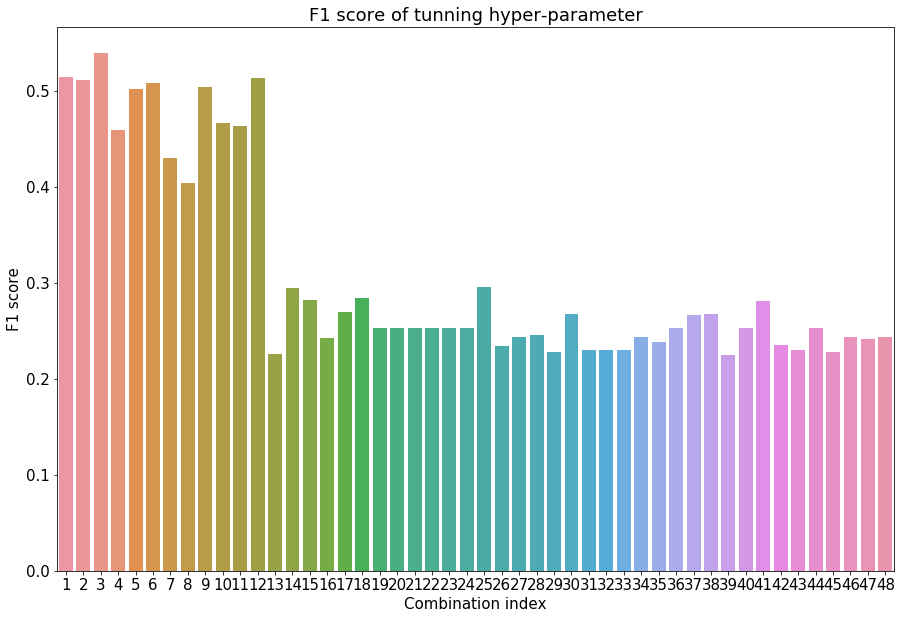

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns

f1score_list = cv_tlp_grid.cv_results_.get('mean_test_score')
plt.figure(figsize=(15,10))
plt.rc('font', size = 15)
plt.title('F1 score of tunning hyper-parameter')
plt.ylabel('F1 score')
plt.xlabel('Combination index')
sns.barplot(x=list(range(1, len(f1score_list)+1)), y=f1score_list)
plt.show()

### use the best performance hyper-parameter above

In [35]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score

params = dict(n_hiddens_size=cv_tlp_grid.best_params_.get('n_hiddens_size'), 
              C=0.1, # tradeoff L2 regularizer
              epochs=350, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              alpha=0.001,
              decrease_const=0.0001,
              shuffle=True,
              minibatches=50,
              act_function=cv_tlp_grid.best_params_.get('act_function'),
              cost_function=cv_tlp_grid.best_params_.get('cost_function'))

grid_best_model = TwoLayerPerceptron(**params)
grid_best_model.fit(X_train, y_train, print_progress=10)
y_hat = grid_best_model.predict(X_test)
print("f1_micro accuracy of using best hyper-parameter: ", f1_score(y_test,y_hat, average='micro')) 

# skf = StratifiedShuffleSplit(n_splits=10)
# f1_list = []
# for iter_num, (train_indices, test_indices) in enumerate(skf.split(X_train, y_train)):
#     grid_best_model.fit(X_train[train_indices], y_train[train_indices], print_progress=10)
#     y_hat = grid_best_model.predict(X_train[test_indices])
#     score_tmp = f1_score(y_train[test_indices],y_hat, average='micro')
#     f1_list.append(score_tmp)
#     # print the accuracy and confusion matrix 
# #     print("====Iteration",iter_num+1," ====")
# #     print("accuracy", f1_score(y_train[test_indices],y_hat, average='micro')) 
# #     print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
# print('-------------------------------------------------------')
# print("Average f1_score accuracy is: " + str(np.mean(f1_list)))

Epoch: 350/350

f1_micro accuracy of using best hyper-parameter:  0.4575


### Gradient magnitude in each iteration

Text(0, 0.5, 'Average gradient magnitude')

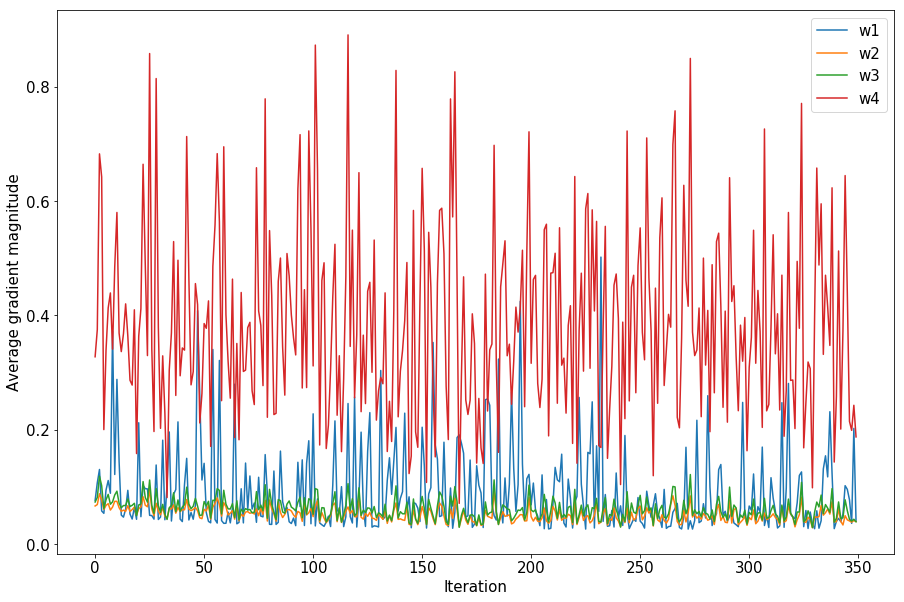

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
x_plot = list(range(1,len(grid_best_model.grad_w_[0])+1))
y_plot = grid_best_model.grad_w_
plt.figure(figsize=(15,10))
# sns.pointplot(x=x_plot, y=y_plot)
for i in range(len(y_plot)):
    str1 = 'w' + str(i+1)
    plt.plot(y_plot[i], label=str1)
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Average gradient magnitude')

# x_plot = list(range(1,len(nn.grad_w_[1])+1))
# y_plot = nn.grad_w_[1]
# plt.figure(figsize=(15,10))
# sns.pointplot(x=x_plot, y=y_plot)

## Exceptional Work

Implement two more phi functions: ReLU and SiLU (also called Swish). Compare their performance to the linear and sigmoid phi functions. 

### ReLU performace

In [37]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# ReLU performance
params = dict(n_hiddens_size=(50,50,50,50), 
              C=0.1, # tradeoff L2 regularizer
              epochs=350, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              alpha=0.001,
              decrease_const=0.0001,
              shuffle=True,
              minibatches=50,
              act_function='relu',
              cost_function='quadratic')

relu_model = TwoLayerPerceptron(**params)

# use 10-folds StratifiedShuffle
relu_skf = StratifiedShuffleSplit(n_splits=10)
relu_score_list = []
for iter_num, (train_indices, test_indices) in enumerate(relu_skf.split(X_train, y_train)):
    relu_model.fit(X_train[train_indices], y_train[train_indices], print_progress=10)
    y_hat = relu_model.predict(X_train[test_indices])
    score_tmp = f1_score(y_train[test_indices],y_hat, average='micro')
    relu_score_list.append(score_tmp)
    # print the accuracy and confusion matrix 
#     print("====Iteration",iter_num+1," ====")
#     print("accuracy", f1_score(y_train[test_indices],y_hat, average='micro')) 

print('ReLU f1_micro accuracy:',np.mean(relu_score_list))

Epoch: 350/350

ReLU f1_micro accuracy: 0.28625


### SiLU performance

In [38]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# SiLU performance
params = dict(n_hiddens_size=(50,50,50,50), 
              C=0.1, # tradeoff L2 regularizer
              epochs=350, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              alpha=0.001,
              decrease_const=0.0001,
              shuffle=True,
              minibatches=50,
              act_function='silu',
              cost_function='quadratic')

silu_model = TwoLayerPerceptron(**params)

silu_skf = StratifiedShuffleSplit(n_splits=10)
silu_score_list = []
for iter_num, (train_indices, test_indices) in enumerate(silu_skf.split(X_train, y_train)):
    silu_model.fit(X_train[train_indices], y_train[train_indices], print_progress=10)
    y_hat = silu_model.predict(X_train[test_indices])
    score_tmp = f1_score(y_train[test_indices],y_hat, average='micro')
    silu_score_list.append(score_tmp)
    # print the accuracy and confusion matrix 
#     print("====Iteration",iter_num+1," ====")
#     print("accuracy", f1_score(y_train[test_indices],y_hat, average='micro')) 

print('ReLU f1_micro accuracy:',np.mean(silu_score_list))

Epoch: 350/350

ReLU f1_micro accuracy: 0.285


### Linear performance

In [39]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# Linear performance
params = dict(n_hiddens_size=(50,50,50,50), 
              C=0.1, # tradeoff L2 regularizer
              epochs=350, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              alpha=0.001,
              decrease_const=0.0001,
              shuffle=True,
              minibatches=50,
              act_function='linear',
              cost_function='quadratic')

linear_model = TwoLayerPerceptron(**params)

linear_skf = StratifiedShuffleSplit(n_splits=10)
linear_score_list = []
for iter_num, (train_indices, test_indices) in enumerate(linear_skf.split(X_train, y_train)):
    linear_model.fit(X_train[train_indices], y_train[train_indices], print_progress=10)
    y_hat = linear_model.predict(X_train[test_indices])
    score_tmp = f1_score(y_train[test_indices],y_hat, average='micro')
    linear_score_list.append(score_tmp)
    # print the accuracy and confusion matrix 
#     print("====Iteration",iter_num+1," ====")
#     print("accuracy", f1_score(y_train[test_indices],y_hat, average='micro')) 

print('ReLU f1_micro accuracy:',np.mean(linear_score_list))

Epoch: 350/350

ReLU f1_micro accuracy: 0.24562500000000004


### Compare their performance

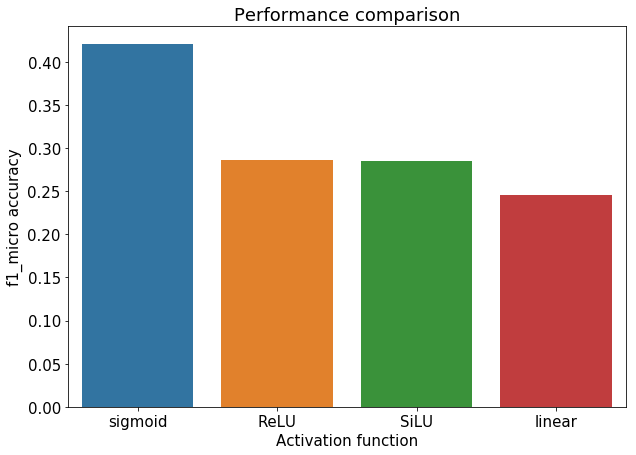

In [40]:
y_scores = [np.mean(sigmoid_score_list), np.mean(relu_score_list), 
            np.mean(silu_score_list), np.mean(linear_score_list)]
plt.figure(figsize=(10,7))
plt.title('Performance comparison')
plt.ylabel('f1_micro accuracy')
plt.xlabel('Activation function')
sns.barplot(x=['sigmoid','ReLU','SiLU','linear'], y=y_scores)

As we can see, when the activation function is sigmoid, the f1_micro has the highest score.